# Linear Regression 구현 해보기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(777)

### 가상 데이터셋

In [2]:
lr = 0.03

# 실제 가중치의 값
W_true = 3.0
B_true = 2.0 

In [3]:
X = tf.random.normal((500, 1)) # X값
noise = tf.random.normal((500, 1)) # noise 값

y = X * W_true + B_true + noise

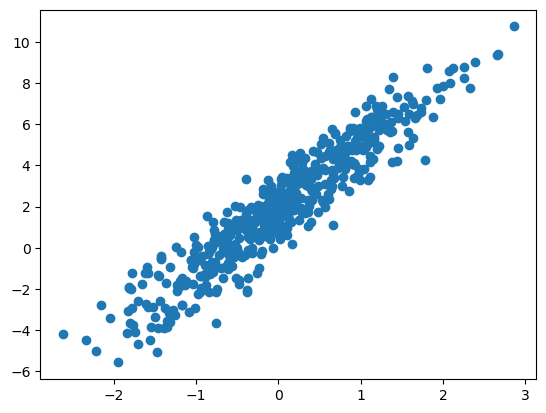

In [4]:
plt.scatter(X, y)
plt.show()

이제 실제 값들을 미분하여 해당 가중치들이 나오는지 확인해보자.

In [5]:
# 미분을 구하기 위해 사용될 변수들
w = tf.Variable(5.)
b = tf.Variable(0.)

In [6]:
# 학습 과정을 기록하기 위한 변수들
w_records = [w.numpy()]
b_records = [b.numpy()]
loss_records = []

for epoch in range(100): # 500개의 데이터셋을 100번 돌겠다.
    # 매 epoch마다 한 번씩 학습
    with tf.GradientTape() as tape:
        y_hat = X * w + b 
        loss = tf.reduce_mean(tf.square(y - y_hat)) # mse
    dw, db = tape.gradient(loss, [w, b]) # gradient 값이 저장됨

    w.assign_sub(lr * dw) # w.assign(w - lr * dw) 와 동일한 기능
    b.assign_sub(lr * db)
    
    # 학습 과정 저장
    w_records.append(w.numpy())
    b_records.append(b.numpy())
    loss_records.append(loss.numpy())


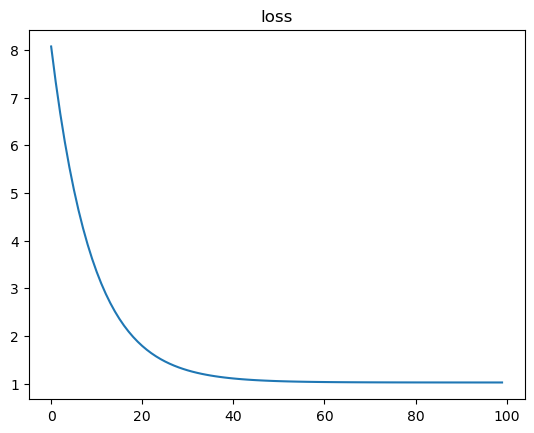

In [7]:
plt.plot(loss_records)
plt.title('loss')
plt.show()

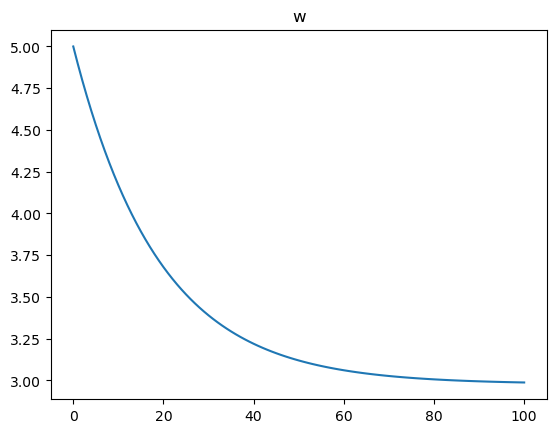

In [8]:
plt.plot(w_records)
plt.title('w')
plt.show()

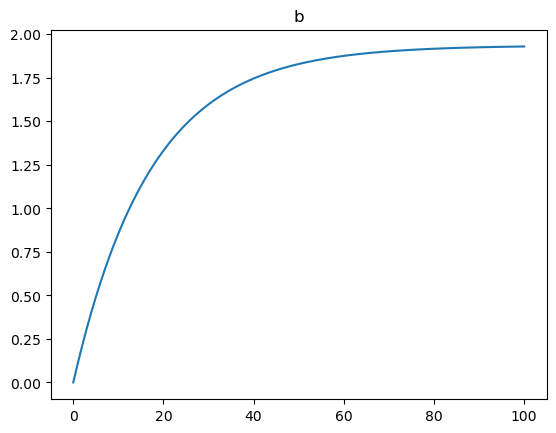

In [9]:
plt.plot(b_records)
plt.title('b')
plt.show()

loss는 점점 떨어지고 w와 b는 w_true와 b_true에 점점 가까워지는 형태를 띄고 있다.

### Dataset 당뇨병 진행도 예측 하기 

In [11]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

diabetes = load_diabetes()
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names, dtype=np.float32)
df['const'] = np.ones(df.shape[0])
df.tail(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,const
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,1.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,1.0
441,-0.045472,-0.044642,-0.073030,-0.081413,0.083740,0.027809,0.173816,-0.039493,-0.004222,0.003064,1.0


#### 먼저!

$X$ 를 Feature, ,$w$를 가중치 벡터, $y$를 Target이라고 할 때, 

$X^T X$의 역행령이 존재 한다고 가정했을 때,  

아래의 식을 이용해 $w$의 추정치 $w^*$를 구해봅시다. 

$$
w^{\ast} = (X^TX)^{-1} X^T y
$$

데이터프레임에 const 컬럼을 추가해두었기 때문에 bias는 const의 가중치가 되므로 위 식에서는 고려하지 않아도 된다.


-----

In [12]:
diabetes.target.shape

(442,)

In [13]:
X = df
y = np.expand_dims(diabetes.target, axis = 1)

X.shape, y.shape

((442, 11), (442, 1))

target의 차원을 하나 늘려줌으로써 X와 y의 차원을 맞춰주었다.

shape때문에 에러가 날 수 있는 경우의 수를 줄여주기 위해 위와 같이 맞춰주는 습관을 길러둘 것!

In [14]:
# tf.transpose(X)는 많이 사용되므로 따로 정의해두자.
XT = tf.transpose(X)
w = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(XT , X)), XT), y)
y_pred = tf.matmul(X, w)

print("예측한 진행도 :", y_pred[0].numpy(),  "실제 진행도 :", y[0])
print("예측한 진행도 :", y_pred[19].numpy(), "실제 진행도 :", y[19])
print("예측한 진행도 :", y_pred[31].numpy(), "실제 진행도 :", y[31])

예측한 진행도 : [206.11667747] 실제 진행도 : [151.]
예측한 진행도 : [124.01754101] 실제 진행도 : [168.]
예측한 진행도 : [69.47575835] 실제 진행도 : [59.]


### 이번에는, SGD 방식으로 구현해보세요!!

- Conditions
    - steepest gradient descents(전체 데이터 사용)
    - 가중치는 Gaussian normal distribution에서의 난수로 초기화함. 
    - step size  == 0.03
    - 100 iteration

In [15]:
lr = 0.03
num_iter = 100

-----

In [16]:
w_init = tf.random.normal([df.shape[1], 1], dtype=tf.float64)
w = tf.Variable(w_init)

In [24]:
# 학습 과정을 기록하기 위한 변수들
w_records = [w.numpy()]
loss_records = []

for epoch in range(num_iter): 
    with tf.GradientTape() as tape:
        y_hat = tf.matmul(X, w)
        loss = tf.reduce_mean(tf.square(y - y_hat))
    dw = tape.gradient(loss, w) 

    w.assign_sub(lr * dw) 
    
    # 학습 과정 저장
    w_records.append(w.numpy())
    loss_records.append(loss.numpy())

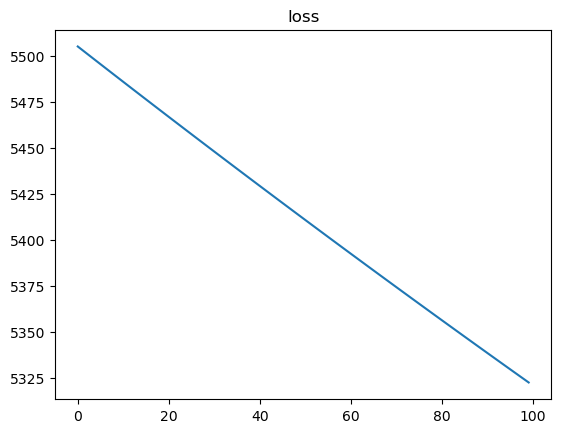

In [25]:
plt.plot(loss_records)
plt.title('loss')
plt.show()

In [26]:
print("예측한 진행도 :", y_hat[0].numpy(),  "실제 진행도 :", y[0])
print("예측한 진행도 :", y_hat[19].numpy(), "실제 진행도 :", y[19])
print("예측한 진행도 :", y_hat[31].numpy(), "실제 진행도 :", y[31])

예측한 진행도 : [155.91650454] 실제 진행도 : [151.]
예측한 진행도 : [146.29034167] 실제 진행도 : [168.]
예측한 진행도 : [140.40297749] 실제 진행도 : [59.]


: 